In [7]:
%matplotlib inline
import argparse
import glob
import logging
import os
import pickle
import random
import re
import csv
from typing import Dict, List, Tuple
import numpy as np
from scipy import stats
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

## Evaluate on top examples

In [2]:
influence_dir = "/project/XLNet_model/influence_func_output"

In [3]:
data_dir = "/project/my_data/"
micro_train = pickle.load(open(data_dir + "ma_train.pkl", 'rb'))
clean_train = pickle.load(open(data_dir + "clean_train.pkl", 'rb'))
hs_train = pickle.load(open(data_dir + "toxic_train.pkl", 'rb'))
micro_adv = pickle.load(open(data_dir + "ma_adv.pkl", 'rb'))

In [4]:
train_dataset = micro_train + clean_train + hs_train
test_dataset = micro_adv

In [5]:
def eval_top_train_ex(examine_type='micro', is_control=False, top_percentage=1.0):
    len_micro_train = len(micro_train)
    len_clean_train = len(clean_train)
    influence = pickle.load(open(f"{influence_dir}/influence_test_idx_1.pkl", "rb"))
    if np.sum(np.isnan(influence)) > 0:
        return None
    if np.max(influence) == np.min(influence):
        return None
    influence = stats.zscore(influence)
    
    inf_sorted_idx = list(np.argsort(influence))
    inf_sorted_idx.reverse()
    correct_ex_rank = []
    correct_ex_score = []
    correct_ex_count = 0
    for i in range(int(len(influence) * top_percentage)):
        if examine_type == "clean":
            if inf_sorted_idx[i] >= len_micro_train and inf_sorted_idx[i] < len_micro_train + len_clean_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        elif examine_type == "micro":
            if inf_sorted_idx[i] < len_micro_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        elif examine_type == "hateful":
            if inf_sorted_idx[i] >= len_micro_train + len_clean_train:
                correct_ex_rank.append(i / len(influence) * 100)
                correct_ex_score.append(influence[inf_sorted_idx[i]])
                correct_ex_count += 1
        else:
            raise ValueError("Check the size of splitting indices of the train set")
    return correct_ex_rank, correct_ex_score, [correct_ex_count / int(len(influence) * top_percentage)]

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogra

avg covert rank: 32.12009846153846
avg non rank: 48.537852884615376
avg overt rank: 72.5387723076923


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


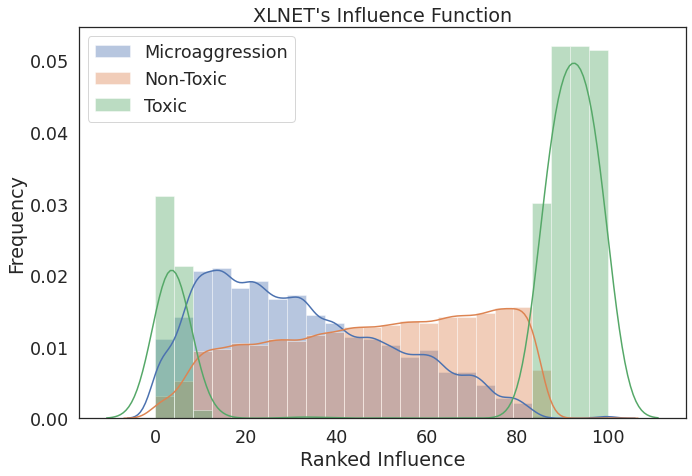

In [6]:
# Default
start_test_idx = 0
end_test_idx = start_test_idx + 100

sns.set_context("paper")
sns.set(style="white", font_scale=1.6)
plt.figure(figsize=(10,7))
bandwidth = 0.1

d = []
_d = []
# for test_idx in range(start_test_idx, end_test_idx):
result = eval_top_train_ex()
if result != None:
    _d.append(result[0])
    for e in result[0]:
        d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Microaggression", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg covert rank:", np.mean(d))

d = []
_d = []
#for test_idx in range(start_test_idx, end_test_idx):
result = eval_top_train_ex(examine_type="clean")
if result != None:
    _d.append(result[0])
    for e in result[0]:
        d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Non-Toxic", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg non rank:", np.mean(d))

d = []
_d = []
# for test_idx in range(start_test_idx, end_test_idx):
result = eval_top_train_ex(examine_type="hateful")
if result != None:
    _d.append(result[0])
    for e in result[0]:
        d.append(e)
_d_np = np.array(_d)
ax = sns.distplot(d, label="Toxic", bins=np.linspace(0, 100, 25), kde_kws={"bw": bandwidth})
print("avg overt rank:", np.mean(d))

ax.set(xlabel='Ranked Influence', ylabel="Frequency", title= "XLNET's Influence Function")
plt.legend()
plt.tight_layout()
plt.show()

## Find top examples to correct

In [8]:
influence_dir = "/project/XLNet_model/influence_func_output"

In [9]:
# data_dir = "resources/processed_dataset/"
# micro_train = pickle.load(open(data_dir + "micro_train.pkl", 'rb'))
# clean_train = pickle.load(open(data_dir + "clean_train.pkl", 'rb'))
# hs_train = pickle.load(open(data_dir + "hs_train.pkl", 'rb'))
# micro_adv = pickle.load(open(data_dir + "micro_adv.pkl", 'rb'))

In [10]:
train_dataset = micro_train + clean_train + hs_train
test_dataset = micro_adv

In [11]:
def get_train_ex_mean_rank(is_control=False):
    len_micro_train = len(micro_train)
    len_clean_train = len(clean_train)
    train_ex_rank_dict = defaultdict(list)
#     for test_idx in range(start_test_idx, end_test_idx):
    influence = pickle.load(open(f"{influence_dir}/influence_test_idx_1.pkl", "rb"))
#     influence = pickle.load(open(f"{influence_dir}/influence_test_idx_1.pkl", "rb"))
    if np.sum(np.isnan(influence)) > 0:
        return None
    if np.max(influence) == np.min(influence):
        return None
    influence = stats.zscore(influence)
    inf_sorted_idx = list(np.argsort(influence))
    inf_sorted_idx.reverse()
    for rank, train_ex_idx in enumerate(inf_sorted_idx):
        train_ex_rank_dict[train_ex_idx].append(rank / len(influence) * 100)
    return train_ex_rank_dict

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


macro avg covert rank: 32.12009846153847
macro avg non rank: 48.537852884615376
macro avg overt rank: 72.5387723076923


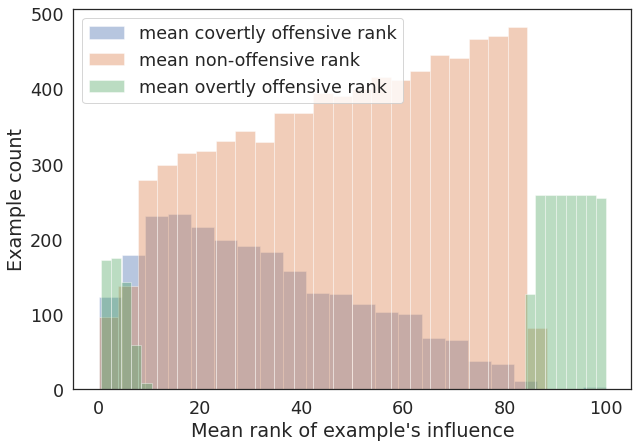

In [12]:
# Default
start_test_idx = 0
end_test_idx = start_test_idx + 100

sns.set_context("paper")
sns.set(style="white", font_scale=1.6)
plt.figure(figsize=(10,7))

train_ex_rank_dict = get_train_ex_mean_rank()

d = []
for i in range(0, len(micro_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean covertly offensive rank", kde=False)
print("macro avg covert rank:", np.mean(d))

d = []
for i in range(len(micro_train), len(micro_train) + len(clean_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean non-offensive rank", kde=False)
print("macro avg non rank:", np.mean(d))

d = []
for i in range(len(micro_train) + len(clean_train), len(micro_train) + len(clean_train) + len(hs_train)):
    d.append(np.mean(train_ex_rank_dict[i]))
ax = sns.distplot(d, label="mean overtly offensive rank", kde=False)
print("macro avg overt rank:", np.mean(d))

ax.set(xlabel='Mean rank of example\'s influence', ylabel="Example count")
plt.legend()
plt.show()

In [25]:
train_ex_rank_dict

defaultdict(list,
            {8966: [0.0],
             6079: [0.007692307692307693],
             7181: [0.015384615384615385],
             1638: [0.023076923076923075],
             3965: [0.03076923076923077],
             6298: [0.038461538461538464],
             4460: [0.04615384615384615],
             3343: [0.05384615384615384],
             6437: [0.06153846153846154],
             655: [0.06923076923076922],
             8854: [0.07692307692307693],
             8578: [0.08461538461538462],
             1721: [0.0923076923076923],
             1797: [0.1],
             1434: [0.10769230769230768],
             2408: [0.11538461538461539],
             3683: [0.12307692307692308],
             806: [0.13076923076923078],
             8154: [0.13846153846153844],
             2343: [0.14615384615384616],
             1636: [0.15384615384615385],
             3361: [0.16153846153846152],
             1699: [0.16923076923076924],
             6411: [0.17692307692307693],
     

In [13]:
train_ex_mean_ranks = []
for i in range(len(train_ex_rank_dict)):
    rank_list = train_ex_rank_dict[i]
    train_ex_mean_ranks.append(np.mean(rank_list))
    
sorted_train_ex_by_mean_inf_rank = list(np.argsort(train_ex_mean_ranks))
sorted_train_ex_for_correction = [e for e in sorted_train_ex_by_mean_inf_rank if e < len(micro_train) + len(clean_train)]

In [14]:
for _i in [50, 100, 200, 500, 1000, 1500, 2000,3000]:
    print(sum([1 if e < len(micro_train) else 0 for e in sorted_train_ex_for_correction[:_i]]), '/', _i)

29 / 50
55 / 100
104 / 200
249 / 500
456 / 1000
655 / 1500
834 / 2000
1183 / 3000


In [19]:
pickle.dump(sorted_train_ex_for_correction, open(f"{influence_dir}/sorted_ex_for_correction.pkl", 'wb')) 